In [11]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import h5py
import sys
import os

In [12]:
# Defin root directory
root = "."
pathogen_code = "mtuberculosis"

# Get models to evaluate
datasets = sorted(os.listdir(os.path.join(root, "..", "output", pathogen_code, "models")))
datasets = [i for i in datasets if "pkl" in i]
assays = set([i.split("_")[0] for i in datasets])

print(f"Number of datasets: {len(datasets)}")
print(f"Number of assays: {len(assays)}")

# Load descriptors
with h5py.File(os.path.join(root, "..", "output", pathogen_code, "descriptors.h5"), "r") as f:
    SMILES = f['SMILES'][:]
    X_Morgan = f['X_Morgan'][:]
    ### add here rdkit descriptors

# Define dict mapping smiles to morgan fingerprints
SMILES_TO_MORGAN = {
    smiles.decode("utf-8"): fp
    for (chembl_id, smiles), fp in zip(SMILES, X_Morgan)}

Number of datasets: 85
Number of assays: 35


In [13]:
RESULTS = []

# For each model
for dataset in datasets:

    # Load model
    results = []
    loaded_model = pickle.load(open(os.path.join(root, "..", "output", pathogen_code, "models", dataset), 'rb'))

    for model_to_compare in datasets:

        # If model
        if dataset == model_to_compare:

            # Load internal CV
            file = os.path.join(root, "..", "output", pathogen_code, "models", dataset.replace('.pkl', '.csv'))
            aurocs = np.array(open(file, "r").readlines()[0].split(","), dtype=float)
            results.append(np.mean(aurocs))

        # else
        else:

            # Load dataset
            data = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, "datasets", model_to_compare.replace('.pkl', '.csv.gz')))
            X = data['canonical_smiles'].astype(str).tolist()
            X = np.array([SMILES_TO_MORGAN[smi] for smi in X])
            Y = data['bin'].astype(np.int8).to_numpy()

            # Predict
            Y_pred = loaded_model.predict_proba(X)[:, 1]

            # Calculate AUROC
            auroc = roc_auc_score(Y, Y_pred)
            results.append(auroc)

    RESULTS.append(results)

RESULTS = np.array(RESULTS)

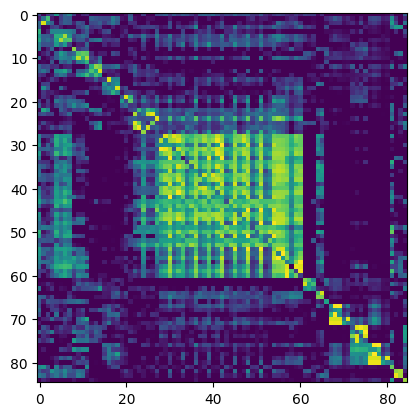

In [14]:
plt.imshow(RESULTS, cmap='viridis', vmin=0.5, vmax=1)
plt.show()